# trying to estimate convergence as a function of sample point number in 1D

Let's assume we are sampling a variable $y$ uniformly over a bounded space $x\in[0, L_d]$.
$N$ is the number of data points collected.

We assume `y` is made of a white noise of amplitude $\sigma$ and a spatially correlated signal over lengthscale $L_s$ (assumed smaller than $L_d$) and of amplitude $\eta$.

*Expectations:*

- For low number of data points, the dataset does not include sufficient pairs of data with separation comparable or smaller than the signal. "Things will go wrong ..."
- For "larger number of data points" (to be better described), we expect to "convergence" to occcur


In [1]:
from tqdm import tqdm

import xarray as xr
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from seaborn import kdeplot

from gptide import cov, GPtideScipy, mcmc
from gptide import stats as gpstats
import corner
import arviz as az

## Set up problem and run for one choice of dataset size N

Text(0.5, 0, 'x')

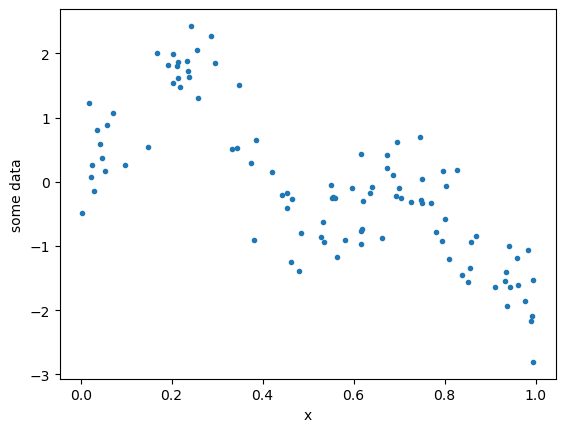

In [2]:
# noise and signal properties
noise = 0.5
η = 1.
Ls = .1 # correlation length scale
covfunc = cov.expquad_1d
covparams = (η, Ls)

# Input data points
Ld = 1 # domain size

# number of data points
N = 100

xd = np.random.uniform(0., Ld, size=(N,1))
#xd = np.arange(0,dx*N,dx)[:,None]


# Initialise the GPtide object and sample from the prior
GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

# Use the .prior() method to obtain some samples
yd = GP.prior(samples=1)

plt.figure()
plt.plot(xd, yd,'.')
plt.ylabel('some data')
plt.xlabel('x')

In [3]:
# Initial guess of the noise and covariance parameters (these can matter)

noise_prior      = gpstats.truncnorm(noise, noise*2, 1e-15, 1e2)                 # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(η, η*2, 1e-15, 1e2),   # η - true value 1.
                    gpstats.truncnorm(Ls, Ls*2, 1e-15, 1e4)  # ℓ - true value 0.1
                   ]

samples, log_prob, priors_out, sampler = mcmc.mcmc( xd,
                                                    yd,
                                                    covfunc,
                                                    covparams_priors,
                                                    noise_prior,
                                                    nwarmup=20,
                                                    niter=20,
                                                    verbose=False)


Running burn-in...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.60it/s]


Running production...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]


In [4]:
# Find sample with highest log prob
i = np.argmax(log_prob)
MAP = samples[i, :]

print('Noise (true): {:3.2f}, Noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('ℓ (true): {:3.2f}, ℓ (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('η (true): {:3.2f}, η (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))

Noise (true): 0.50, Noise (mcmc): 0.50
ℓ (true): 1.00, ℓ (mcmc): 1.61
η (true): 0.10, η (mcmc): 0.21


/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


0.5 Axes(0.125,0.11;0.227941x0.77)
1.0 Axes(0.398529,0.11;0.227941x0.77)
0.1 Axes(0.672059,0.11;0.227941x0.77)


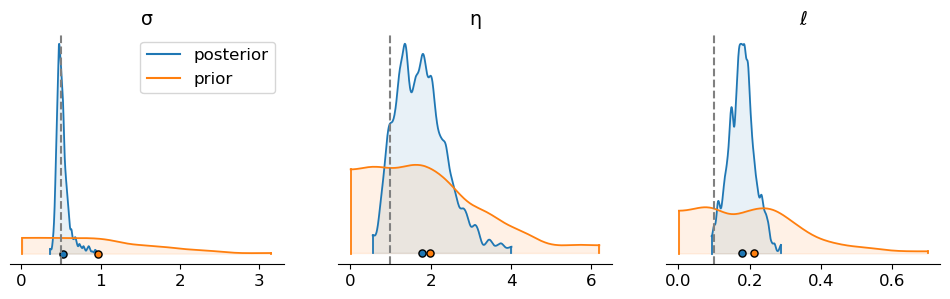

In [5]:
# posterior density plot

labels = ['σ','η','ℓ']
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels],
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 3),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

for t, ax in zip([noise,]+list(covparams), axs[0]):
    print(t, ax)
    ax.axvline(t, color="0.5", ls="--")

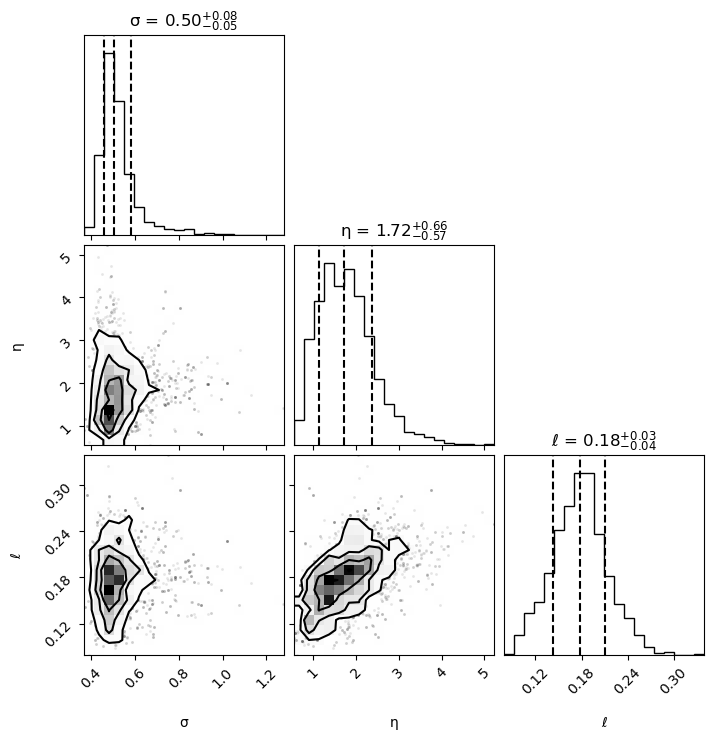

In [6]:
fig = corner.corner(samples,
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

(array([101., 102., 102.,  71.,  56.,  34.,  23.,   6.,   3.,   2.]),
 array([0.01269649, 0.36521558, 0.71773466, 1.07025375, 1.42277284,
        1.77529192, 2.12781101, 2.4803301 , 2.83284919, 3.18536827,
        3.53788736]),
 <BarContainer object of 10 artists>)

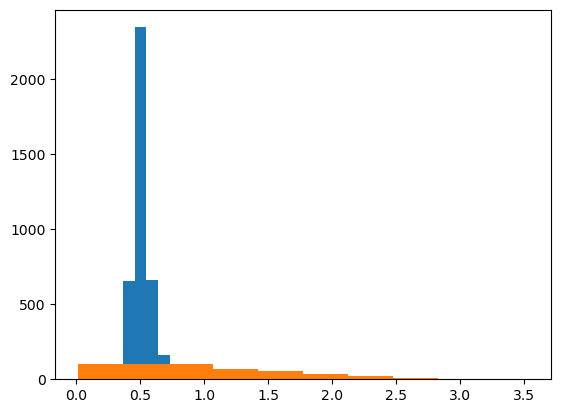

In [7]:
plt.hist(samples[:,0])
plt.hist(priors_out[:,0])

---
## loop over multiple N values, collect results and inspect

In [8]:
# Initial guess of the noise and covariance parameters (these can matter)
noise_prior      = gpstats.truncnorm(noise, noise*2, 1e-15, 1e2)                 # noise - true value 0.5
covparams_priors = [gpstats.truncnorm(η, η*2, 1e-15, 1e2),   # η - true value 1.
                    gpstats.truncnorm(Ls, Ls*2, 1e-15, 1e4)  # ℓ - true value 0.1
                   ]

def inference(N):

    # generate data
    xd = np.random.uniform(0., Ld, size=(N,1))

    ## Initialise the GPtide object and sample from the prior
    GP = GPtideScipy(xd, xd, noise, covfunc, covparams)

    # Use the .prior() method to obtain some samples
    yd = GP.prior(samples=1)
    
    samples, log_prob, priors_out, sampler = mcmc.mcmc( xd,
                                                        yd,
                                                        covfunc,
                                                        covparams_priors,
                                                        noise_prior,
                                                        nwarmup=20,
                                                        niter=20,
                                                        verbose=False,
                                                        progress=False,
                                                      )

    # Find sample with highest log prob
    i = np.argmax(log_prob)
    MAP = samples[i, :]
    
    ds = xr.Dataset(
        dict(noise_prior=(("pr",), priors_out[:,0]),
             noise_posterior=(("po",), samples[:,0]),
             eta_prior=(("pr",), priors_out[:,1]),
             eta_posterior=(("po",), samples[:,1]),
             Ls_prior=(("pr",), priors_out[:,2]),
             Ls_posterior=(("po",), samples[:,2]),
        )
    )
    # compute quantiles
    

    return ds

In [9]:
I = {}
for n in tqdm(np.logspace(1, 3, 10, dtype=int)):
    I[n] = inference(n)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [20:14<00:00, 121.46s/it]


In [10]:
for n, ds in I.items():
    print(n, ds.po.size, ds.pr.size)
# could probably concatenate I in a single dataset, not doing for now in case, output size become N dependent

10 4000 500
16 4000 500
27 4000 500
46 4000 500
77 4000 500
129 4000 500
215 4000 500
359 4000 500
599 4000 500
1000 4000 500


Text(0, 0.5, '')

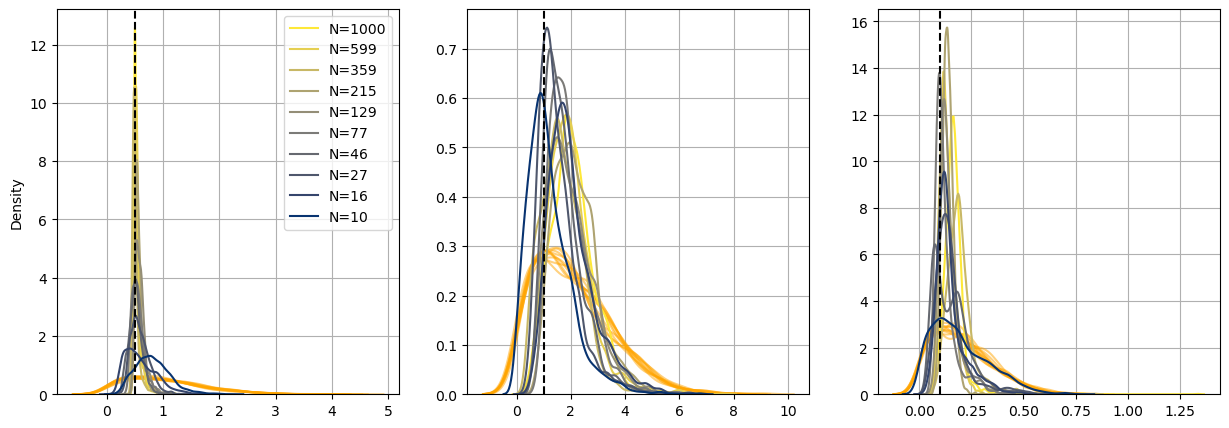

In [11]:
cmap = plt.get_cmap('cividis_r')

#n = 10
fig, axes = plt.subplots(1,3, figsize=(15,5))

ax = axes[0]
for i, n in enumerate(reversed(I)):
    p = kdeplot(I[n]["noise_prior"], color="orange", ax=ax, alpha=0.5)
for i, n in enumerate(reversed(I)):
    p = kdeplot(I[n]["noise_posterior"], color=cmap(i/len(I)), label=f"N={n}", ax=ax)    
ax.grid()
ax.legend()
ax.axvline(noise, color="k", ls="--")

ax = axes[1]
for i, n in enumerate(reversed(I)):
    p = kdeplot(I[n]["eta_prior"], color="orange", ax=ax, alpha=0.5)
for i, n in enumerate(reversed(I)):
    p = kdeplot(I[n]["eta_posterior"], color=cmap(i/len(I)), ax=ax)    
ax.grid()
ax.axvline(covparams[0], color="k", ls="--")
ax.set_ylabel("")

ax = axes[2]
for i, n in enumerate(reversed(I)):
    p = kdeplot(I[n]["Ls_prior"], color="orange", ax=ax, alpha=0.5)
for i, n in enumerate(reversed(I)):
    p = kdeplot(I[n]["Ls_posterior"], color=cmap(i/len(I)), label=f"N={n}", ax=ax)    
ax.grid()
ax.axvline(covparams[1], color="k", ls="--")
ax.set_ylabel("")

In [12]:
quantiles = [0.1, 0.5, 0.9]

_noise_qt = xr.concat([ds.noise_posterior.quantile(quantiles) for n, ds in I.items()], dim=pd.Index(list(I), name="N"))
_eta_qt = xr.concat([ds.eta_posterior.quantile(quantiles) for n, ds in I.items()], dim=pd.Index(list(I), name="N"))
_Ls_qt = xr.concat([ds.Ls_posterior.quantile(quantiles) for n, ds in I.items()], dim=pd.Index(list(I), name="N"))

_noise_mean = xr.concat([ds.noise_posterior.mean() for n, ds in I.items()], dim=pd.Index(list(I), name="N"))
_eta_mean = xr.concat([ds.eta_posterior.mean() for n, ds in I.items()], dim=pd.Index(list(I), name="N"))
_Ls_mean = xr.concat([ds.Ls_posterior.mean() for n, ds in I.items()], dim=pd.Index(list(I), name="N"))

perf = xr.merge(
    [_noise_qt.rename("noise_qt"), _eta_qt.rename("eta_qt"), _Ls_qt.rename("Ls_qt"),
     _noise_mean.rename("noise_mean"), _eta_mean.rename("eta_mean"), _Ls_mean.rename("Ls_mean"),
    ],
)

Text(0.5, 1.0, 'Ls posterior quantiles')

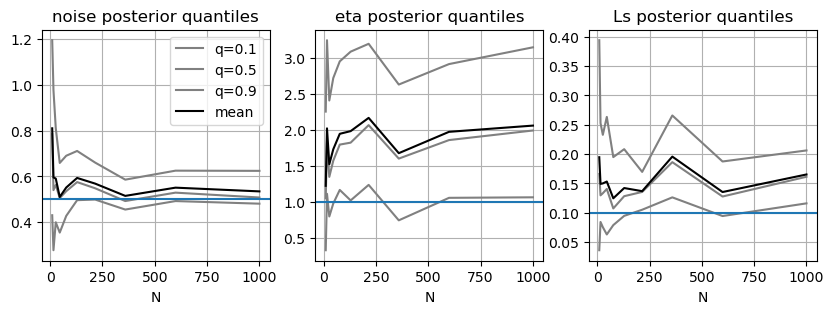

In [13]:
fig, axes = plt.subplots(1,3, figsize=(10,3))

ax = axes[0]
for q, c in zip(perf["quantile"], ["0.5", "0.5", "0.5"]):
    da = perf["noise_qt"].sel(quantile=q)
    da.plot(x="N", ax=ax, color=c, label=f"q={float(q)}")
perf["noise_mean"].plot(x="N", ax=ax, color="k", label=f"mean")
ax.grid()
ax.axhline(noise)
ax.set_ylabel("")
ax.legend()
ax.set_title("noise posterior quantiles")

ax = axes[1]
for q, c in zip(perf["quantile"], ["0.5", "0.5", "0.5"]):
    da = perf["eta_qt"].sel(quantile=q)
    da.plot(x="N", ax=ax, color=c, label=f"q={float(q)}")
perf["eta_mean"].plot(x="N", ax=ax, color="k", label=f"mean")
ax.grid()
ax.axhline(covparams[0])
ax.set_ylabel("")
ax.set_title("eta posterior quantiles")

ax = axes[2]
for q, c in zip(perf["quantile"], ["0.5", "0.5", "0.5"]):
    da = perf["Ls_qt"].sel(quantile=q)
    da.plot(x="N", ax=ax, color=c, label=f"q={float(q)}")
perf["Ls_mean"].plot(x="N", ax=ax, color="k", label=f"mean")
ax.grid()
ax.axhline(covparams[1])
ax.set_ylabel("")
ax.set_title("Ls posterior quantiles")
